# *Library and file dependancies*

*Libraries*

In [1]:
# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")

*Single cell utility functions*

In [2]:
from utils.plotting import *
from utils.optimization import *

*data file path*

In [3]:
filepath = 'datasets/'

# 1. **Preprocessing**

## **Data formatting** 

The original counts matrix is in txt format, where the columns are cells and the rows are genes. For this reason we load the dataset into a pandas dataframe and:
1. Remove the gene_id and gene_type columns
2. Set the gene name column as the index
3. Transpose the Dataframe

Finally we can load the Dataframe into an AnnData object, readable by scanpy. 

In [4]:
# Pass the txt file into a csv via pandas with tab delimeter
df = pd.read_csv(filepath+"GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt", delimiter="\t")
df.drop(['gene_id','gene_type'], axis = 1, inplace = True)
df.set_index('gene_name', drop=True, inplace=True)
df = df.rename_axis(None)
df  = df.T
adata = sc.AnnData(df.values)
adata.var_names = df.columns  # Assign column names as feature (gene) names
adata.obs_names = df.index  # Assign row names as observation names (cell or sample names)
adata.var_names_make_unique() # In case of repeatring genes, make the unique
adata.obs_names

Index(['BC01_Pooled', 'BC01_Tumor', 'BC02_Pooled', 'BC03_Pooled',
       'BC03LN_Pooled', 'BC04_Pooled', 'BC05_Pooled', 'BC06_Pooled',
       'BC07_Tumor', 'BC07LN_Pooled',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', length=563)

However, as you can see in the adata object observation we also have pooled tumour samples. Thus we will seperate the information into two adata objects:
- One for pooled cell counts `padata` 
- One for cell counts `cadata`

In [5]:
# Cell adata 
cadata = adata[14:]
print(f"Cell adata obvervations: {cadata.obs_names}\n")
padata = adata[:14]
print(f"Pool cell adata observations: {padata.obs_names}\n")

Cell adata obvervations: Index(['BC01_02', 'BC01_03', 'BC01_04', 'BC01_05', 'BC01_06', 'BC01_08',
       'BC01_10', 'BC01_11', 'BC01_12', 'BC01_24',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', length=549)

Pool cell adata observations: Index(['BC01_Pooled', 'BC01_Tumor', 'BC02_Pooled', 'BC03_Pooled',
       'BC03LN_Pooled', 'BC04_Pooled', 'BC05_Pooled', 'BC06_Pooled',
       'BC07_Tumor', 'BC07LN_Pooled', 'BC08_Pooled', 'BC09_Pooled',
       'BC10_Pooled', 'BC11_Pooled'],
      dtype='object')



Another very important step is to assign each cell population to a tumor group. Cells are named by "BC":PREFIX + "02-11":PATIENT + "_" + "cell number", thus we can remove the specific cell number and only keep the patient tumor identifier "BC02" to "BC011".

In [6]:
tumor_groups = [obs_name if "Pooled" in obs_name else obs_name.split("_")[0] for obs_name in cadata.obs_names]
cadata.obs['tumor_groups'] = tumor_groups
# For example the first gorup of cells should belong to the tumor of patient one 
cadata.obs['tumor_groups'].head()

BC01_02    BC01
BC01_03    BC01
BC01_04    BC01
BC01_05    BC01
BC01_06    BC01
Name: tumor_groups, dtype: object

## **Quality Control**

During quality control, we exclude cells with a small number of detected genes, low count depth, and a high proportion of mitochondrial counts, as these characteristics may suggest a compromised cell membrane and indicate cell death. Since these cells are typically not the primary focus of our analysis and have the potential to affect the accuracy of our subsequent analysis, we remove them from our dataset.

In [44]:
# mitochondrial genes
cadata.var["mt"] = cadata.var_names.str.startswith("MT-")
print(f"print len(cadata)")
# ribosomal genes
cadata.var["ribo"] = cadata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
cadata.var["hb"] = cadata.var_names.str.contains(("^HB[^(P)]"))

Before proceeding with cell & gene filtering we annotate quality control metrics to the counts matrix via scanpy's `calculate_qc_metrics` for the `cell_adata` counts matrix.

In [50]:
sc.pp.calculate_qc_metrics(cadata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
cadata

AnnData object with n_obs × n_vars = 549 × 28034
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'ribo', 'hb'

 - For cells (obs):,
    - n_genes_by_counts -> The number of genes that were expressed in each cell,
    - total_counts -> The total expression level measured in each cell,
    - log1p >> -> Corresponds to the above information, but log transformed to reduce the impact of extremely high or low expression values
    
- For genes (var):,
    - n_cells_by_counts -> The number of cells in which each gene is expressed,
    - total_counts -> The total expression level of each gene across all cells,
    - mean_counts -> Represents the average expression level of each gene across all cells,
    - log1p >> -> Corresponds to the above information, but log transformed to reduce the impact of extremely high or low expression values,
    - pct_dropout_by_counts -> The percentage of cells in which each gene is not detected or expressed

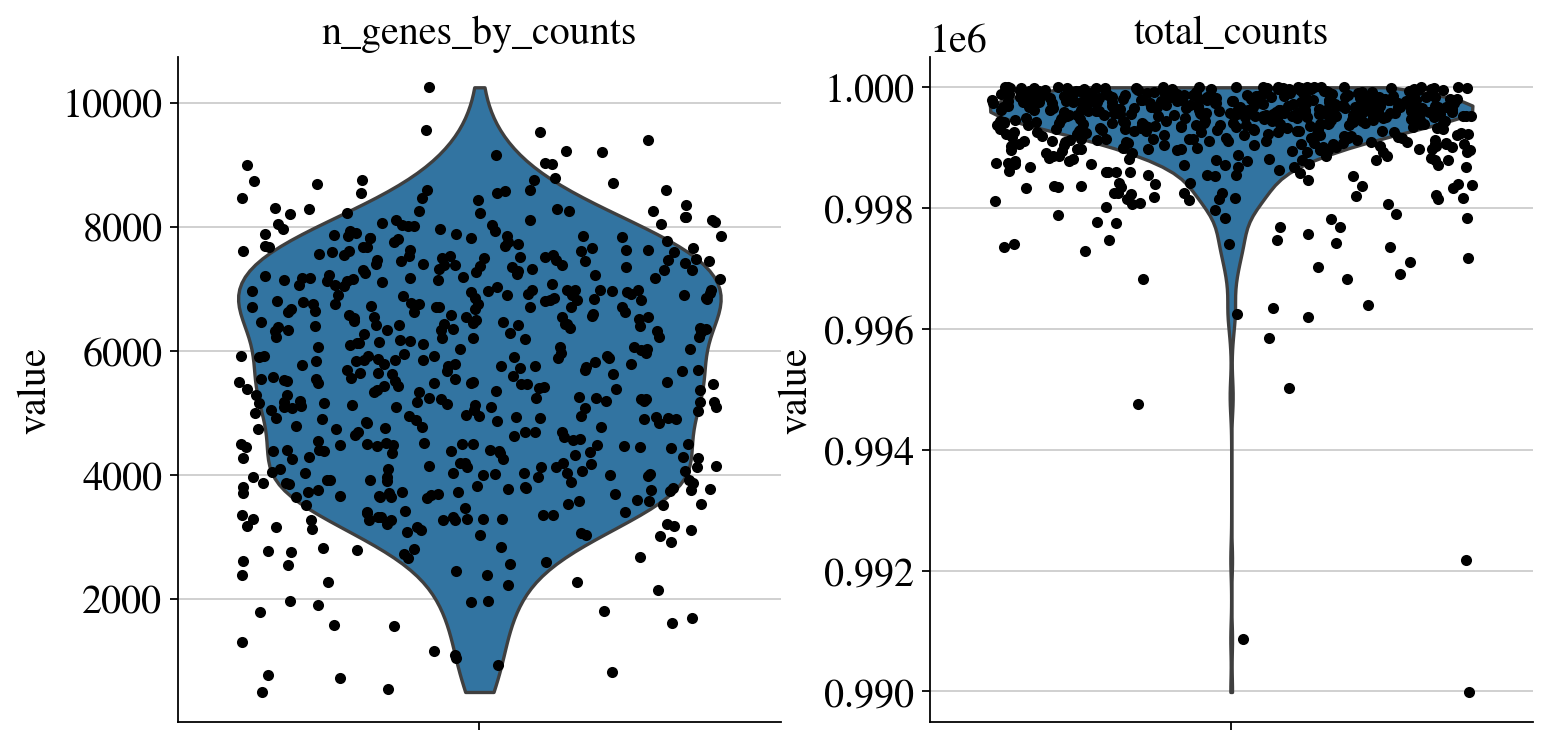

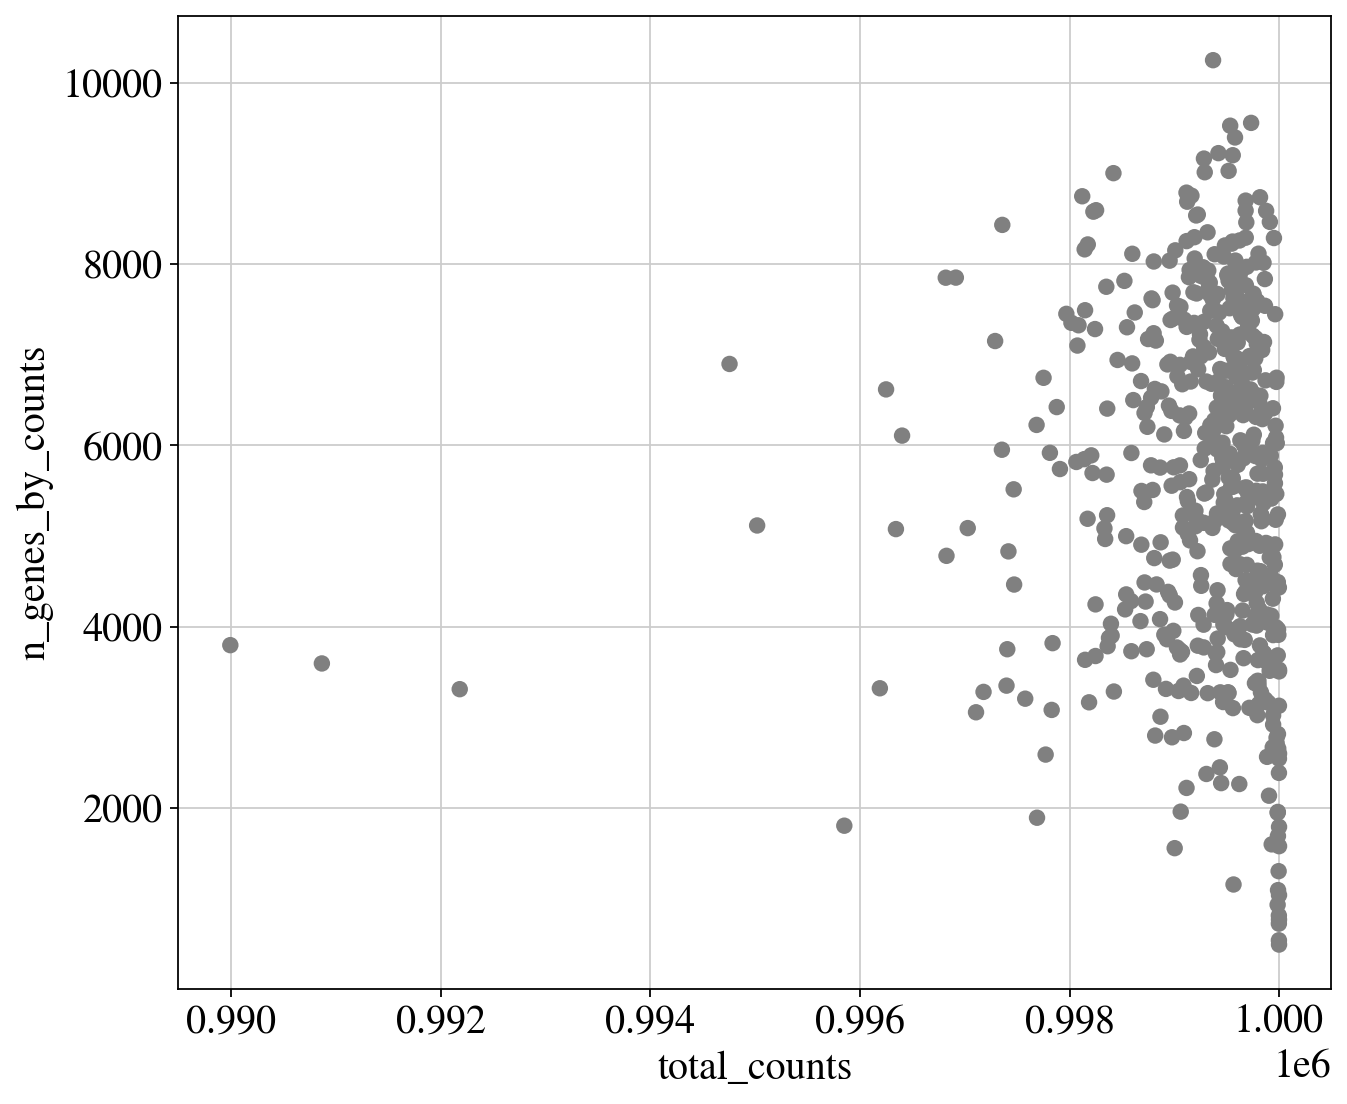

In [43]:
sc.pp.filter_cells(cadata, min_genes=200)
sc.pp.filter_genes(cadata, min_cells=3)
sc.pp.calculate_qc_metrics(cadata,percent_top = None,log1p= True,inplace = True)
sc.pl.violin(cadata, ['n_genes_by_counts', 'total_counts'],size = 5,jitter=0.4, multi_panel=True)
sc.pl.scatter(cadata, x='total_counts', y='n_genes_by_counts')

We can now create an instance of the scGmix class to handle preprocessing.

In [9]:
sc.pp.calculate_qc_metrics(cadata,percent_top = None,log1p = True,inplace = True)
cadata

AnnData object with n_obs × n_vars = 549 × 57915
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

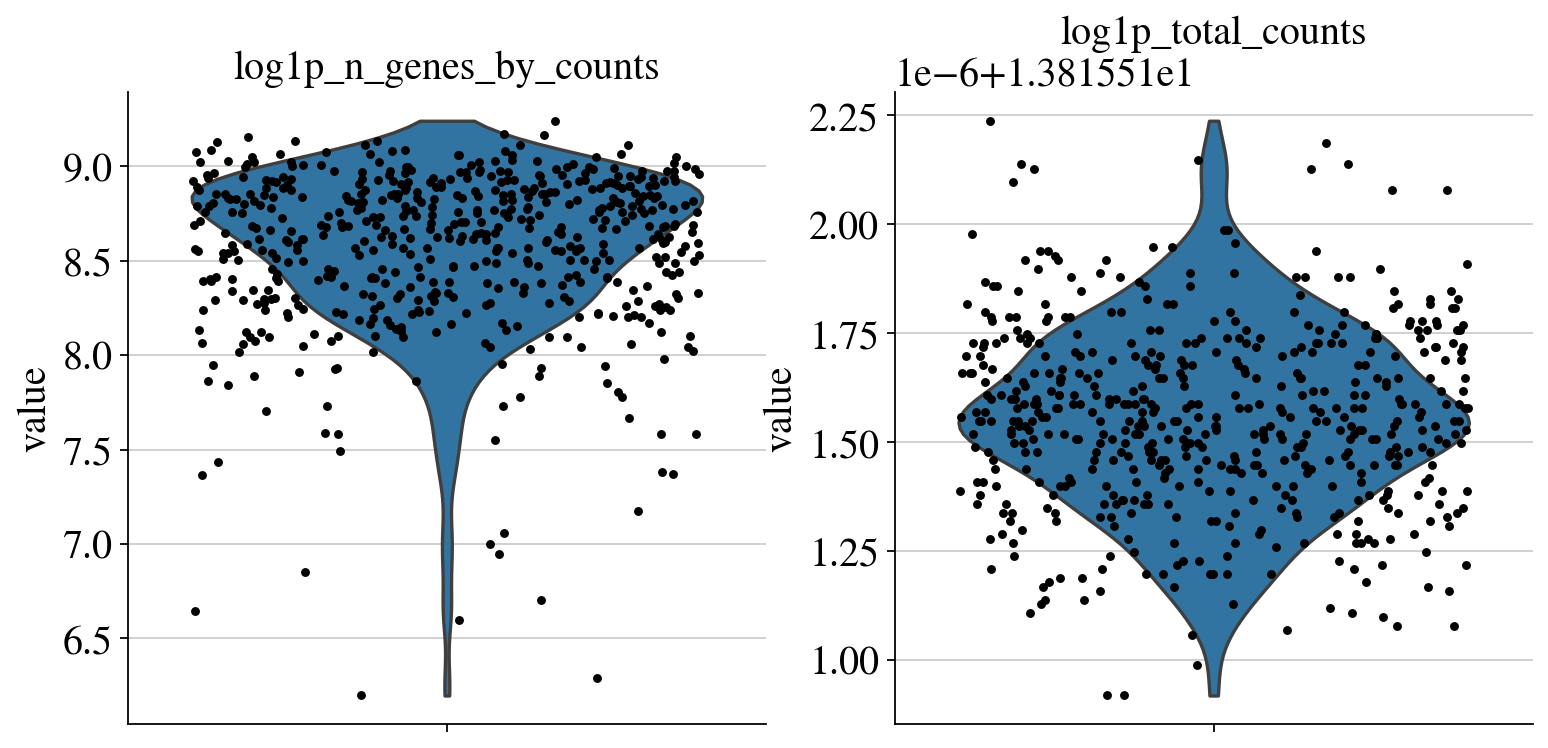

In [10]:
sc.pl.violin(cadata, ['log1p_n_genes_by_counts', 'log1p_total_counts'],size = 4,
             jitter=0.4, multi_panel=True)

## *Cell Filtering*
To remove cells with low-quality sequencing values, four filtering criteria were applied:
- Number of total reads
- Mapping rate
- Number of detected genes
- Portion of intergenic region
Utilizing these criteria, the authors choose to removed the following cells, as described in [Supplementary Data 3](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms15081/MediaObjects/41467_2017_BFncomms15081_MOESM467_ESM.xlsx)

We end up with 515 cells, from the original 549.

In [11]:
drop_list = ['BC01_Tumor','BC01_11', 'BC01_24', 'BC01_49', 'BC01_54', 'BC02_27', 'BC02_33', 'BC02_80', 'BC03_45', 'BC03_51', 'BC03_63', 'BC03_88', 'BC03LN_77', 'BC03LN_87', 'BC04_05', 'BC04_06', 'BC04_15', 'BC04_25', 'BC05_40', 'BC06_07', 'BC06_09', 'BC06_22','BC06_45',  'BC06_49', 'BC06_57', 'BC06_62', 'BC07_96', 'BC07LN_20', 'BC08_12','BC09_02', 'BC09_27', 'BC09_54', 'BC09_Re_68', 'BC09_Re_72','BC10_27']
adata = adata[~adata.obs_names.isin(drop_list)]
adata

View of AnnData object with n_obs × n_vars = 528 × 57915

## *Gene Filtering, attempt to follow the authors approach to reach 17,779 genes*
Gene filtering was conducted following:
  1. Transcripts Per Million(TPM) values $<$1 were considered unreliable and substituted with zero.

In [12]:
adata.X = np.where(adata.X < 1, 0, adata.X)

  2. TPM values were log2-transformed after adding a value of one.

In [13]:
sc.pp.log1p(adata,base = 2)

  3. Genes expressed in <10% of all tumour groups were removed.

In [14]:
# 10% of the 13 tumor groups is 1.3
threshold = 1.3
df = pd.DataFrame(cell_adata.X, columns=cell_adata.var_names)
# Add the 'tumour_group' annotation as a column in the DataFrame
groups = cell_adata.obs['tumor_groups'].copy()
df['tumor_groups'] = groups.values
grouped_data = df.groupby('tumor_groups')
# Sum the expression and convert any expression value > 0 to 1 to binarize expression
gene_sums = grouped_data.sum()
gene_sums[gene_sums > 0] = 1
# Create a mask that removes genes that are expressed in less than 10% of all clusters
mask = (gene_sums.sum() < threshold)
# Filter the cells 
adata = adata[:, ~mask]

NameError: name 'cell_adata' is not defined

As you can see we end up with 27527 genes rather than 17779 with this method

In [ ]:
sc.pp.pca(adata)

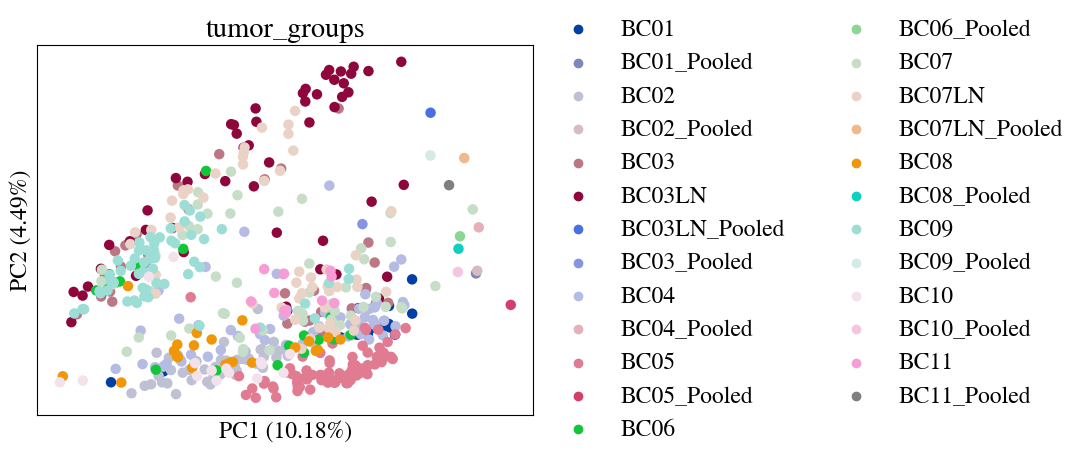

In [ ]:
sc.pl.pca(adata, color='tumor_groups',annotate_var_explained = True)
plt.show()